In [186]:
import pandas as pd
import numpy as np

df = pd.read_csv("mrk_project_csv.csv")

## Remove 0,6 in the overall ratings
df['Q7ALL'] = df['Q7ALL'].replace(['BLANK','6','0'],np.NaN)
df['Q7ALL'].dropna(inplace = True)
d = df['Q7ALL'].astype('int64', inplace=True)

#### Clustering

In [187]:
df_q7 = df[list(df.columns[35:50])].dropna()
X_q7 = df_q7.iloc[:,:-1]

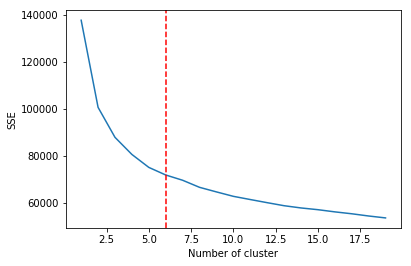

In [188]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

sse = {}

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_q7.index.values

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k,random_state=50).fit(X_q7)
    cluster_map['cluster'] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.axvline(x=6, c='r', linestyle='--')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [189]:
clus_num = 6
kmeans = KMeans(clus_num,random_state=50).fit(X_q7)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_
X_reset = X_q7.reset_index().drop(columns='index')
for i in range(clus_num):
    print(X_reset[cluster_map['cluster']==i].shape)

(230, 14)
(1520, 14)
(532, 14)
(766, 14)
(1111, 14)
(1154, 14)


In [190]:
from sklearn.linear_model import LinearRegression
from scipy import stats

for i in range(clus_num):
    
    X = X_reset[cluster_map['cluster']==i].reset_index().drop(columns='index')
    y = df['Q7ALL'].reset_index().drop(columns='index').astype('float64')[cluster_map['cluster']==i]['Q7ALL']

    lm = LinearRegression().fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    #sd_b = np.round(sd_b,3)
    #ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    #params = np.round(params,4)

    result = pd.DataFrame()
    result["Coefficients"],result["Standard Errors"],result["t values"],result["Probabilites"] = [params,sd_b,ts_b,p_values]
    l = list(X.columns)
    l.insert(0,'intercept')
    result['Name'] = l
    col = ['Name', 'Coefficients', 'Standard Errors', 't values', 'Probabilites']
    result = result[col]
    print('Cluster: ',i+1,'\n',result,'\n\n')

Cluster:  1 
            Name  Coefficients  Standard Errors   t values  Probabilites
0     intercept      3.497359         0.151817  23.036632         0.000
1         Q7ART     -0.005214         0.036950  -0.141113         0.888
2        Q7FOOD      0.036062         0.048448   0.744346         0.457
3       Q7STORE     -0.004159         0.047060  -0.088370         0.930
4        Q7SIGN      0.180560         0.051454   3.509133         0.001
5     Q7WALKWAY     -0.027730         0.057256  -0.484320         0.629
6     Q7SCREENS     -0.027477         0.052843  -0.519980         0.604
7    Q7INFODOWN     -0.072484         0.045368  -1.597696         0.111
8      Q7INFOUP     -0.033500         0.046031  -0.727787         0.467
9        Q7WIFI      0.078857         0.035451   2.224370         0.027
10      Q7ROADS     -0.002524         0.036184  -0.069754         0.944
11       Q7PARK      0.047939         0.049288   0.972615         0.332
12   Q7AIRTRAIN     -0.033284         0.039144  -0

#### PCA regression

In [191]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = X_reset.reset_index().drop(columns='index')
y = df['Q7ALL'].reset_index().drop(columns='index').astype('float64')

stdScaler = StandardScaler()
X_scaled = stdScaler.fit_transform(X)

pca = PCA(n_components = 3)
pca_result = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(data = pca_result, columns = ['PC1', 'PC2', 'PC3'])
print(pd.DataFrame(pca.components_,columns=X.columns,index = ['PC1','PC2','PC3']))

        Q7ART    Q7FOOD   Q7STORE    Q7SIGN  Q7WALKWAY  Q7SCREENS  Q7INFODOWN  \
PC1 -0.224093 -0.221996 -0.237928 -0.228474  -0.256709  -0.251071   -0.296190   
PC2 -0.190911 -0.242240 -0.250830 -0.302375  -0.283641  -0.300044   -0.128810   
PC3  0.152532  0.310605  0.251817  0.194870   0.169047   0.071022   -0.573472   

     Q7INFOUP    Q7WIFI   Q7ROADS    Q7PARK  Q7AIRTRAIN  Q7LTPARKING  Q7RENTAL  
PC1 -0.291070 -0.238849 -0.282562 -0.302983   -0.298603    -0.296685 -0.290565  
PC2 -0.145433 -0.102077  0.269686  0.336425    0.312397     0.363373  0.341089  
PC3 -0.582564 -0.180570  0.172436  0.058319    0.084886     0.013200  0.062281  


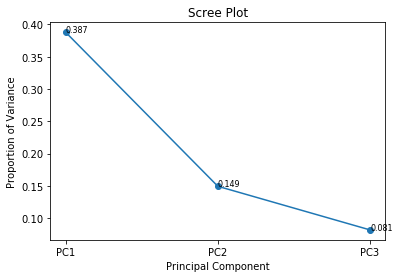

In [192]:
pca_list = ['PC1', 'PC2', 'PC3']
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance')
plt.plot(pca_list, pca.explained_variance_ratio_, marker='o')
for a,b in zip(pca_list, pca.explained_variance_ratio_): 
    plt.text(a, b, str(b)[0:5], fontsize=8)
plt.show()

In [193]:
for i in range(clus_num):
    
    X_pca_clust = X_pca[cluster_map['cluster']==i].reset_index().drop(columns='index')
    y_pca = y[cluster_map['cluster']==i].reset_index().drop(columns='index')['Q7ALL']
        
    lm = LinearRegression().fit(X_pca_clust,y_pca)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X_pca_clust)

    newX = pd.DataFrame({"Constant":np.ones(len(X_pca_clust))}).join(pd.DataFrame(X_pca_clust))
    MSE = (sum((y_pca-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    #sd_b = np.round(sd_b,3)
    #ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    #params = np.round(params,4)

    result = pd.DataFrame()
    result["Coefficients"],result["Standard Errors"],result["t values"],result["Probabilites"] = [params,sd_b,ts_b,p_values]
    l = ['PC1','PC2','PC3']
    l.insert(0,'intercept')
    result['Name'] = l
    col = ['Name', 'Coefficients', 'Standard Errors', 't values', 'Probabilites']
    result = result[col]
    print('Cluster: ',i+1,'\n',result,'\n')

Cluster:  1 
         Name  Coefficients  Standard Errors  t values  Probabilites
0  intercept      3.465643         0.358642  9.663230         0.000
1        PC1      0.025975         0.040019  0.649063         0.517
2        PC2     -0.096726         0.042128 -2.295999         0.023
3        PC3      0.094862         0.036495  2.599349         0.010 

Cluster:  2 
         Name  Coefficients  Standard Errors   t values  Probabilites
0  intercept      4.323952         0.047599  90.840676         0.000
1        PC1      0.004920         0.020637   0.238433         0.812
2        PC2     -0.232352         0.021611 -10.751692         0.000
3        PC3      0.137809         0.024098   5.718727         0.000 

Cluster:  3 
         Name  Coefficients  Standard Errors   t values  Probabilites
0  intercept      3.826293         0.099228  38.560722         0.000
1        PC1     -0.144735         0.028496  -5.079203         0.000
2        PC2      0.027488         0.025825   1.064416        

#### Correlation

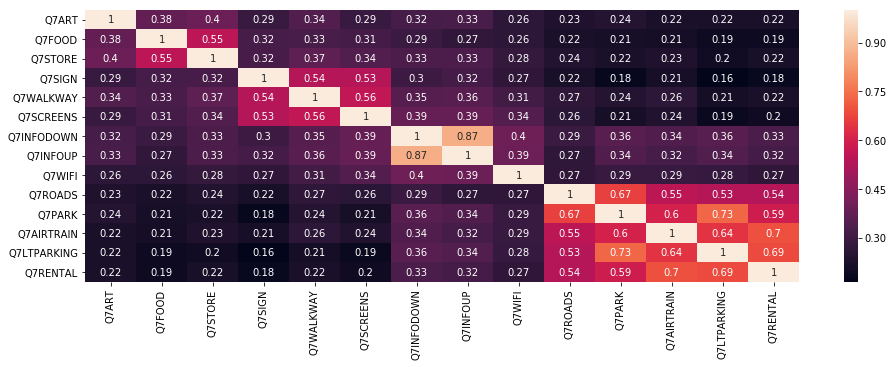

In [177]:
import seaborn as sns
corr = X_q7.corr()
plt.figure(figsize = (16,5))
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot = True)

In [196]:
X_binned = pd.DataFrame()

X_binned['Art'] = X_q7['Q7ART']
X_binned['Food&Store'] = X_q7[['Q7FOOD','Q7STORE']].mean(axis=1)
X_binned['Direction'] = X_q7[['Q7SIGN','Q7WALKWAY','Q7SCREENS']].mean(axis=1)
X_binned['InfoBooth'] = X_q7[['Q7INFODOWN','Q7INFOUP']].mean(axis=1)
X_binned['Transportation'] = X_q7[['Q7ROADS','Q7PARK','Q7AIRTRAIN','Q7LTPARKING','Q7RENTAL']].mean(axis=1)
X_binned['Wifi'] = X_q7['Q7WIFI']

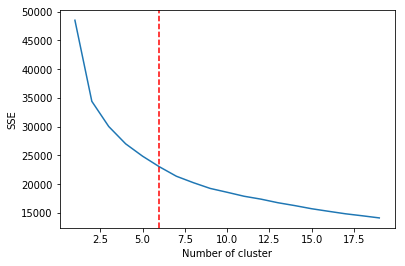

In [199]:
sse_binned = {}

cluster_map_binned = pd.DataFrame()
cluster_map_binned['data_index'] = X_binned.index.values

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k,random_state=50).fit(X_binned)
    cluster_map_binned['cluster'] = kmeans.labels_
    #print(data["clusters"])
    sse_binned[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse_binned.keys()), list(sse_binned.values()))
plt.axvline(x=6, c='r', linestyle='--')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [201]:
clus_num = 6
kmeans = KMeans(clus_num,random_state=50).fit(X_binned)
cluster_map_binned = pd.DataFrame()
cluster_map_binned['data_index'] = X.index.values
cluster_map_binned['cluster'] = kmeans.labels_
X_reset_binned = X_binned.reset_index().drop(columns='index')
for i in range(clus_num):
    print(X_reset_binned[cluster_map_binned['cluster']==i].shape)

(509, 6)
(990, 6)
(1327, 6)
(130, 6)
(634, 6)
(1723, 6)


In [203]:
for i in range(clus_num):
    
    X_binned_clust = X_reset_binned[cluster_map_binned['cluster']==i].reset_index().drop(columns='index')
    y = df['Q7ALL'].reset_index().drop(columns='index').astype('float64')[cluster_map_binned['cluster']==i]['Q7ALL']

    lm = LinearRegression().fit(X_binned_clust,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X_binned_clust)

    newX = pd.DataFrame({"Constant":np.ones(len(X_binned_clust))}).join(pd.DataFrame(X_binned_clust))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    #sd_b = np.round(sd_b,3)
    #ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    #params = np.round(params,4)

    result = pd.DataFrame()
    result["Coefficients"],result["Standard Errors"],result["t values"],result["Probabilites"] = [params,sd_b,ts_b,p_values]
    l = list(X_binned.columns)
    l.insert(0,'intercept')
    result['Name'] = l
    col = ['Name', 'Coefficients', 'Standard Errors', 't values', 'Probabilites']
    result = result[col]
    print('Cluster: ',i+1,'\n',result,'\n\n')

Cluster:  1 
              Name  Coefficients  Standard Errors  t values  Probabilites
0       intercept      2.226042         0.304122  7.319581         0.000
1             Art     -0.008899         0.024889 -0.357574         0.721
2      Food&Store      0.096687         0.027451  3.522184         0.000
3       Direction      0.349496         0.038276  9.130949         0.000
4       InfoBooth     -0.038452         0.030807 -1.248155         0.213
5  Transportation     -0.011654         0.032515 -0.358428         0.720
6            Wifi      0.060390         0.028713  2.103215         0.036 


Cluster:  2 
              Name  Coefficients  Standard Errors   t values  Probabilites
0       intercept      2.824511         0.296695   9.519912         0.000
1             Art      0.102880         0.017161   5.995114         0.000
2      Food&Store      0.148625         0.019197   7.741997         0.000
3       Direction      0.309540         0.025461  12.157516         0.000
4       InfoBoo